In [1]:
using Printf
using DelimitedFile

include("pnormdiffusion.jl");
include("sweepcut.jl");

## Load graph

In [2]:
# Load edge list
edgelist = readdlm("datasets/Colgate88_edgelist.txt", '\t', Int, '\n');

# Create adjacency list
n = maximum(edgelist)
adjlist = [Int[] for i in 1:n]
for edge in eachrow(edgelist)
    push!(adjlist[edge[1]], edge[2])
    push!(adjlist[edge[2]], edge[1])
end

## Load target cluster, i.e., students of year 2008

In [3]:
# For details about the ground-truth target cluster please refer to:
# K. Fountoulakis, D. Wang, S. Yang. p-Norm Flow Diffusion for Local Graph Clustering. ICML 2020.

target_cluster = vec(readdlm("datasets/Colgate88_year2008.txt", ' ', Int, '\n'));

## Run p-Norm Flow Diffusion

In [4]:
seednode = 3345;
seedmass = 200000;
seedset = Dict(seednode => seedmass);

degree = [length(l) for l in adjlist];

###### p = 2

In [5]:
x = pnormdiffusion(adjlist, degree, seedset, p=2);
cluster, cond = sweepcut(adjlist, degree, x);

In [6]:
tp = length(intersect(Set(target_cluster),Set(cluster)));
pr = tp/length(cluster);
re = tp/length(target_cluster);
@printf "Conductance is %.2f\n" cond
@printf "Prcision is %.2f\n" pr
@printf "Recall is %.2f\n" re
@printf "F1 score is %.2f\n" 2*pr*re/(pr+re)

Conductance is 0.29
Prcision is 0.87
Recall is 0.92
F1 score is 0.90


###### p = 4

In [7]:
x = pnormdiffusion(adjlist, degree, seedset, p=4);
cluster, cond = sweepcut(adjlist, degree, x);

In [8]:
tp = length(intersect(Set(target_cluster),Set(cluster)));
pr = tp/length(cluster);
re = tp/length(target_cluster);
@printf "Conductance is %.2f\n" cond
@printf "Prcision is %.2f\n" pr
@printf "Recall is %.2f\n" re
@printf "F1 score is %.2f\n" 2*pr*re/(pr+re)

Conductance is 0.28
Prcision is 0.90
Recall is 0.95
F1 score is 0.92


# Visualization of target cluster and local clustering results

In [9]:
using PyCall
using PyPlot

nx = pyimport("networkx");
plt = pyimport("matplotlib.pyplot");

In [10]:
# Load graph to Networkx
G = nx.read_edgelist("datasets/Colgate88_edgelist.txt");

# Load pre-computed coordinates for nodes
pos = readdlm("datasets/Colgate88_pos.txt", ' ', Float64, '\n');
pos_dict = Dict(string(i) => (xy[1],xy[2]) for (i,xy) in enumerate(eachrow(pos)));

###### Target cluster

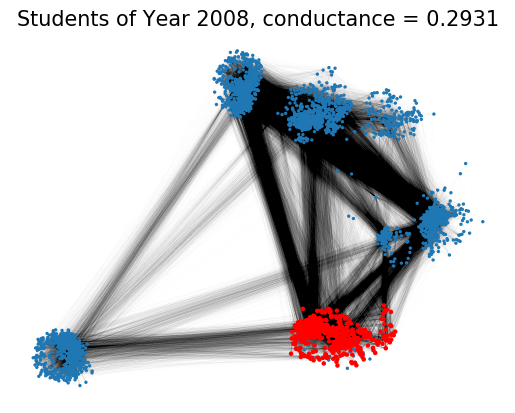

In [11]:
# Visualize students of year 2008

n1 = setdiff(Set(1:n),Set(target_cluster))
nl = [string(i) for i in n1];
nc = ["tab:blue" for _ in n1];
ns = [2 for _ in n1];
for i in target_cluster
    push!(nl, string(i))
    push!(nc, "r")
    push!(ns, 5)
end

plt.subplots()
plt.axes(frameon=false)
nx.draw_networkx_nodes(G, pos_dict, nodelist=nl, node_size=ns, node_color=nc)
nx.draw_networkx_edges(G, pos_dict, width=0.1, edge_color="k", alpha=0.05)
plt.title("Students of Year 2008, conductance = 0.2931", size=15)
plt.show()

###### Returned clusters

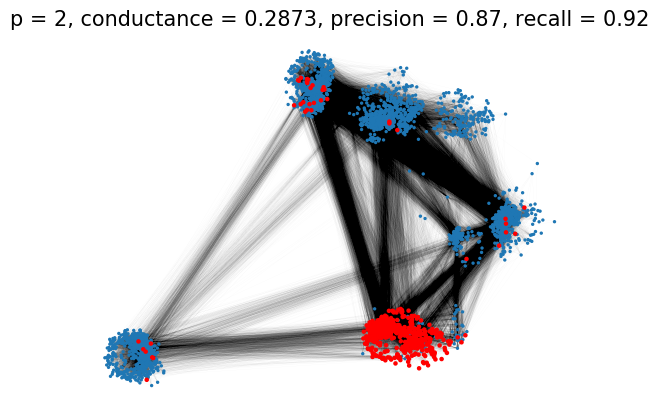

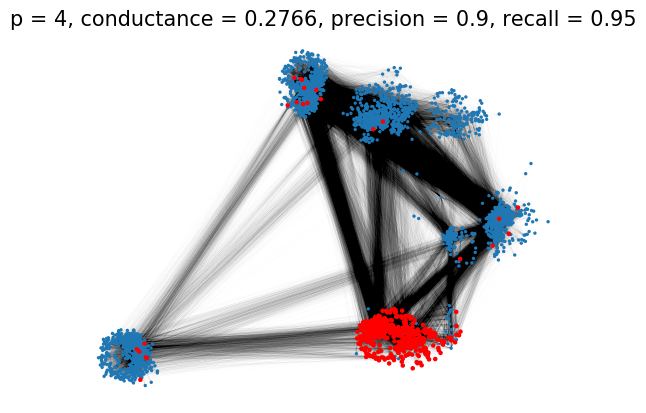

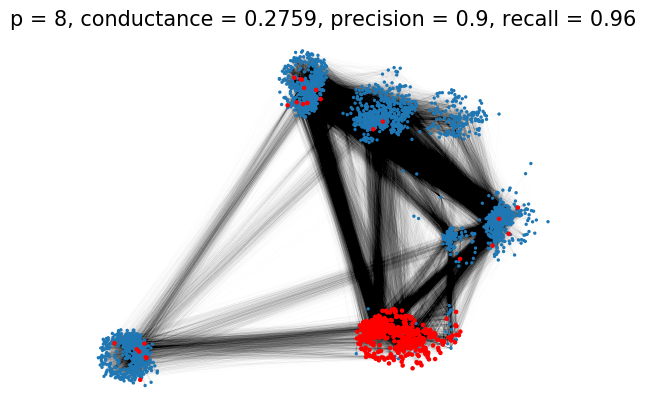

In [12]:
for p in [2,4,8]
    
    x = pnormdiffusion(adjlist, degree, seedset, p=p, max_iters=100);
    cluster, cond = sweepcut(adjlist, degree, x);
    
    tp = length(intersect(Set(target_cluster),Set(cluster)));
    pr = tp/length(cluster);
    re = tp/length(target_cluster); 
    
    n1 = setdiff(Set(1:n),Set(cluster))
    nl = [string(i) for i in n1];
    nc = ["tab:blue" for _ in n1];
    ns = [2 for _ in n1];
    for i in cluster
        push!(nl, string(i))
        push!(nc, "r")
        push!(ns, 5)
    end    
    plt.subplots()
    plt.axes(frameon=false)
    plt.title("p = "*string(p)*", conductance = "*string(round(1.0e4*cond)/1.0e4)*
        ", precision = "*string(round(100*pr)/100)*", recall = "*string(round(100*re)/100), size=15) 
    nx.draw_networkx_nodes(G, pos_dict, nodelist=nl, node_size=ns, node_color=nc)
    nx.draw_networkx_edges(G, pos_dict, width=0.1, edge_color="k", alpha=0.05)
    plt.show()
    
end